# Regularized Gaussian priors for recovering linear PDEs

**Notice**
- You need FEniCS-2019 and CUQIpy to run this notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils import Poisson2D
import cuqi
import dolfin as df
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.implicitprior import RegularizedGMRF
from cuqi.experimental.mcmc import RegularizedLinearRTO, LinearRTO

In [2]:
from skimage.restoration import denoise_tv_chambolle

In [ ]:
import matplotlib 

fontsize = 20
legendfontsize = 20

matplotlib.rc('xtick', labelsize=fontsize)
matplotlib.rc('ytick', labelsize=fontsize) 

## Preparation of forward model and synthetic data

Here we corrupt the data with Gaussian noise with mean at zero and standard deviation `noise_scale`.

In [4]:
np.random.seed(0)
# %%
nx = 64
poisson = Poisson2D(nx, nx)
# %%
y_exact = poisson.solve_exact()
noise_scale = 0.3 #0.1 #0.05 #0.002
noise = noise_scale*np.random.randn(y_exact.size)
y_data = y_exact + noise


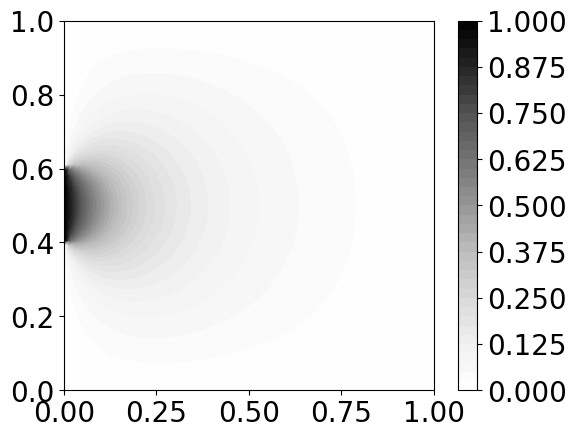

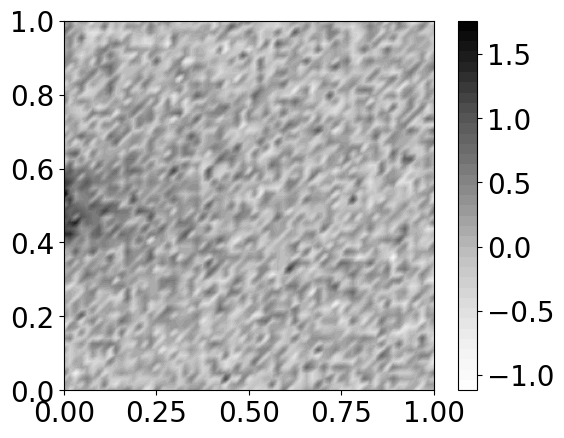

In [5]:
# %%
plt.figure()
poisson.sol.vector()[:] = y_exact
im = df.plot(poisson.sol, cmap='Greys')
cbar=plt.colorbar(im)
plt.figure()
poisson.sol.vector()[:] = y_data
im = df.plot(poisson.sol, 'o', cmap='Greys')
plt.colorbar(im, ticks=[-1, -0.5, 0, 0.5, 1, 1.5])
plt.savefig("rhs_data.pdf", bbox_inches='tight')

## Solve the inverse problem in CUQIpy

### With GMRF only

In [6]:
# %%
model_func = cuqi.model.LinearModel(poisson.forward, adjoint=poisson.adjoint, range_geometry=poisson.V.dim(), domain_geometry=len(poisson.left_bc_dofs))

In [7]:
no_of_samples = 1000

In [8]:
# GMRF with fixed precision as 1e-1
np.random.seed(0)
x = cuqi.distribution.GMRF(np.zeros(nx+1), 1e-1)
y = Gaussian(model_func(x), noise_scale**2)

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_gmrf_smaller = LinearRTO(posterior)
sampler_gmrf_smaller.sample(no_of_samples)
samples_gmrf_smaller = sampler_gmrf_smaller.get_samples()

Sample: 100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s, acc rate: 100.00%]


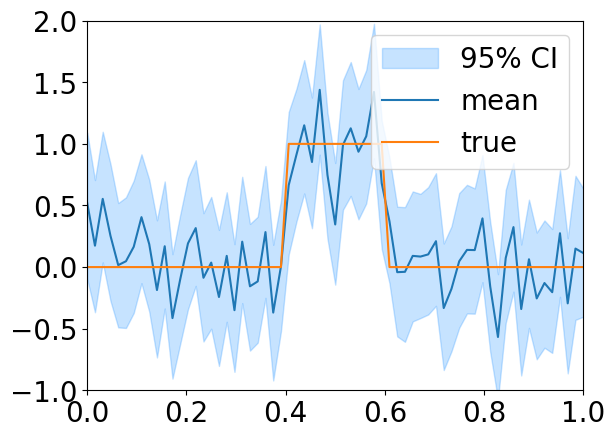

In [9]:
samples_gmrf_smaller.geometry.grid = np.linspace(0, 1, nx+1)
samples_gmrf_smaller.plot_ci(exact=np.array(list(poisson.bc_left.get_boundary_values().values())))
plt.legend(['95% CI', 'mean', 'true'], fontsize=fontsize, loc="upper right")
plt.xlim([0, 1])
plt.ylim([-1, 2])
plt.savefig("rhs_gmrf.pdf", bbox_inches='tight')

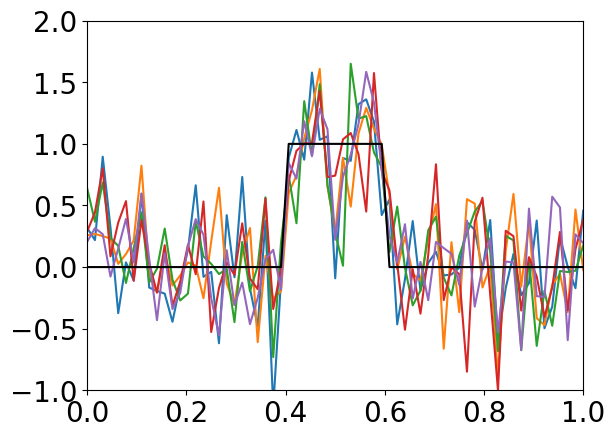

In [10]:
plt.plot(np.linspace(0,1,65), samples_gmrf_smaller.samples[:,100], color="C0", label="Samples")
plt.plot(np.linspace(0,1,65), samples_gmrf_smaller.samples[:,200], color="C1")
plt.plot(np.linspace(0,1,65), samples_gmrf_smaller.samples[:,300], color="C2")
plt.plot(np.linspace(0,1,65), samples_gmrf_smaller.samples[:,400], color="C3")
plt.plot(np.linspace(0,1,65), samples_gmrf_smaller.samples[:,500], color="C4")
plt.plot(np.linspace(0,1,65), np.array(list(poisson.bc_left.get_boundary_values().values())), label='Exact', color='k')
plt.ylim([-1, 2])
plt.xlim([0, 1])
# plt.legend(fontsize=legendfontsize, loc="upper right")
plt.savefig("rhs_gmrf_samples.pdf", bbox_inches='tight')

### With TV prior

In [11]:
w = 25#25 #the greater the weight, the more denoising
proximal = lambda x, scale : denoise_tv_chambolle(x, weight=w*scale)

In [12]:
# regularized GMRF with TV regularization
np.random.seed(0)
x = RegularizedGMRF(np.zeros(nx+1), 1e-1, proximal = proximal)
y = Gaussian(model_func(x), noise_scale**2)

# posterior interface
joint = JointDistribution(y, x)
posterior = joint(y=y_data)

sampler_rgmrf_tv = RegularizedLinearRTO(posterior, maxit=25)
sampler_rgmrf_tv.sample(no_of_samples)
samples_rgmrf_tv = sampler_rgmrf_tv.get_samples()

Sample: 100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s, acc rate: 100.00%]


In [13]:
samples_rgmrf_tv.geometry.grid = np.linspace(0, 1, nx+1)

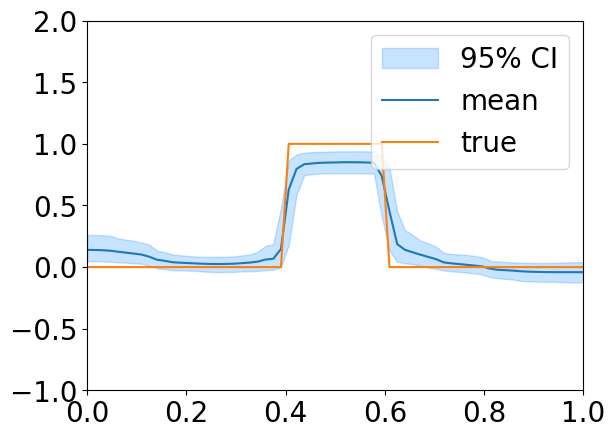

In [14]:
samples_rgmrf_tv.plot_ci(exact=np.array(list(poisson.bc_left.get_boundary_values().values())))
plt.legend(['95% CI', 'mean', 'true'], fontsize=fontsize, loc="upper right")
plt.xlim([0, 1])
plt.ylim([-1, 2])
plt.savefig("rhs_gmrf_tv.pdf", bbox_inches='tight')

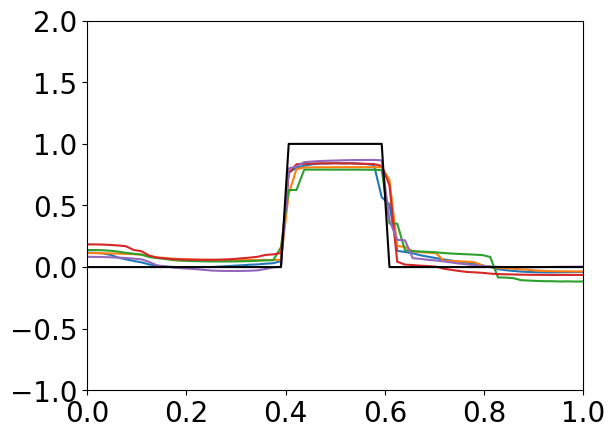

In [15]:
plt.plot(np.linspace(0,1,65), samples_rgmrf_tv.samples[:,100], color="C0", label="Samples")
plt.plot(np.linspace(0,1,65), samples_rgmrf_tv.samples[:,200], color="C1")
plt.plot(np.linspace(0,1,65), samples_rgmrf_tv.samples[:,300], color="C2")
plt.plot(np.linspace(0,1,65), samples_rgmrf_tv.samples[:,400], color="C3")
plt.plot(np.linspace(0,1,65), samples_rgmrf_tv.samples[:,500], color="C4")
plt.plot(np.linspace(0,1,65), np.array(list(poisson.bc_left.get_boundary_values().values())), label='Exact', color='k')
plt.ylim([-1, 2])
plt.xlim([0, 1])
plt.savefig("rhs_gmrf_tv_samples.pdf", bbox_inches='tight')